<a href="https://colab.research.google.com/github/vijayrgopu/ml-analyticsvidhya/blob/master/LoanPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analytics Vidhya Loan Prediction Problem III**

**Problem Statement**

**About Company**
Dream Housing Finance company deals in all home loans. They have presence across all urban, semi urban and rural areas. Customer first apply for home loan after that company validates the customer eligibility for loan.

**Problem**
Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers. Here they have provided a partial data set.



In [0]:
!pip install missingno -q

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as ms
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
!wget "https://www.dropbox.com/s/vrqparlu16o8ssz/train_u6lujuX_CVtuZ9i.csv?dl=0" -q

In [0]:
!mv train_u6lujuX_CVtuZ9i.csv* loan.csv 

In [0]:
data = pd.read_csv("loan.csv")

In [0]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB


In [0]:
#ms.matrix(data)

# **Feature Engineering**



# > Gender






In [0]:
#identify mean income by gender and area
income_by_gender_Area = data[['Gender','Property_Area','ApplicantIncome']]
income_by_gender_Area.pivot_table(index=['Gender','Property_Area'],values=['ApplicantIncome'],aggfunc=np.mean)

ApplicantIncome
Gender Property_Area                 
Female Rural              4353.375000
       Semiurban          4787.272727
       Urban              4614.787879
Male   Rural              5691.291391
       Semiurban          5412.529070
       Urban              5258.909639

In [0]:
#Feature Engineering: Imputing missing values for Gender
#data.loc[(data.Gender.isnull())]

In [0]:
#Function to impure Gender by applicant Income and partner income
def impute_gen(cols):
  Gender = cols['Gender']
  CoapplicantIncome = cols['CoapplicantIncome']
  ApplicantIncome = cols['ApplicantIncome']
  
  if type(Gender) is str : 
    return cols['Gender']
  else:
    if CoapplicantIncome > 0 and ApplicantIncome > CoapplicantIncome:
       return str('Male')
    else:
      if ApplicantIncome < 5000:
          return str('Female')
      else:  
          return str('Male')

In [0]:
#Impute Gender
data['Gender'] = data[['Gender','ApplicantIncome','CoapplicantIncome']].apply(impute_gen,axis=1)



# > **Marital Status**



In [0]:
#Imputing marital status
def impute_marital_status(cols):
    Married = cols[0]
    ApplicantIncome = cols[1]
    CoapplicantIncome = cols[2]
    
    if type(Married) is str:
      return cols[0]
    else:
      if CoapplicantIncome > 0:
        return str('Yes')
      else:
        return str('No')
    

In [0]:
data['Married'] = data[['Married','ApplicantIncome','CoapplicantIncome']].apply(impute_marital_status,axis=1)



# > **Dependents**

Imputing Zero as dependents as this is not provided by the applicant, may have high propability on the decision of approval for a loan.



In [0]:
data['Dependents'] = data[['Dependents']].where(data.Dependents.notnull(),other=str(0))



# > **Employment_Type**



In [0]:
def impute_employment(cols):
  Employed = cols[0]
  Education = cols[1]
  
  if type(Employed) is str:
    return Employed
  else:
    if Education == "Graduate":
      return str('Yes')
    else:
      return str('No')

In [0]:
data['Self_Employed'] = data[['Self_Employed','Education']].apply(impute_employment,axis=1)



# > **Loan Amount Ratio**

Will calculate loan amount ratio and drop the rows where the loan amount is missing as this is a key criteria for prediction



In [0]:
data['Total_Income'] = data.ApplicantIncome + data.CoapplicantIncome

In [0]:
data['Loan_Income_Perc'] = round(data.LoanAmount*1000/data.Total_Income,2)

In [0]:
data_by_area_loanstatus_incomeperc = data[['Property_Area','Loan_Status','Loan_Income_Perc']]
pd.pivot_table(data_by_area_loanstatus_incomeperc,index=['Property_Area','Loan_Status'],values=['Loan_Income_Perc'],aggfunc=np.mean)

Loan_Income_Perc
Property_Area Loan_Status                  
Rural         N                   24.817121
              Y                   23.640187
Semiurban     N                   25.958491
              Y                   23.828629
Urban         N                   23.534194
              Y                   22.410155



# > **Credit History**
Default 0 if credit history is missing



In [0]:
data['Credit_History'] = data['Credit_History'].where(data.Credit_History.notnull(),other=0)



# > **Loan Amount Term**




In [0]:
data_loan_amount_term_cal = data[['Loan_Status','Property_Area','Loan_Income_Perc','Loan_Amount_Term']]
pd.pivot_table(data_loan_amount_term_cal,index=['Loan_Status','Property_Area'],values=['Loan_Income_Perc'],aggfunc=np.mean)

Loan_Income_Perc
Loan_Status Property_Area                  
N           Rural                 24.817121
            Semiurban             25.958491
            Urban                 23.534194
Y           Rural                 23.640187
            Semiurban             23.828629
            Urban                 22.410155

In [0]:
pd.pivot_table(data_loan_amount_term_cal,index=['Loan_Status','Property_Area'],values=['Loan_Amount_Term'],aggfunc=np.mean)

Loan_Amount_Term
Loan_Status Property_Area                  
N           Rural                345.134328
            Semiurban            345.509434
            Urban                341.818182
Y           Rural                345.777778
            Semiurban            347.593220
            Urban                328.186047

In [0]:
#verify loan amount term data for less than 20 ratio
#data[data.Loan_Income_Perc < 20]

In [0]:
#data[(data.Loan_Income_Perc > 19)& (data.Loan_Income_Perc < 20) & (data.Loan_Status == 'N')]

In [0]:
#save the list to verify the data after imputing
loan_amt_term_idx = data[data.Loan_Amount_Term.isnull() == True].index.tolist()
#data.iloc[loan_amt_term_idx]

In [0]:
def impute_loan_term(cols):
  Loan_Status = cols[0]
  Property_Area = cols[1]
  Loan_Income_Perc = cols[2]
  Loan_Term = cols[3]
  
  if Loan_Term > 0:
    return Loan_Term
  else:
    if Loan_Status == 'N' and Property_Area == "Rural" and Loan_Income_Perc > 24:
      return float(360)
    if Loan_Status == 'N' and Property_Area == "Semiurban" and Loan_Income_Perc > 25:
      return float(360)
    if Loan_Status == 'N' and Property_Area == "Urban" and Loan_Income_Perc > 23:
      return float(360)
    if Loan_Status == 'Y' and Property_Area == "Rural" and Loan_Income_Perc > 23 and Loan_Income_Perc < 24:
      return float(345)
    if Loan_Status == 'Y' and Property_Area == "Semiurban" and Loan_Income_Perc > 23 and Loan_Income_Perc < 24:
      return float(347)
    if Loan_Status == 'Y' and Property_Area == "Urban" and Loan_Income_Perc > 22 and Loan_Income_Perc < 23:
      return float(328)
    if Loan_Income_Perc > 10:
      return float(360)
    if Loan_Income_Perc < 10:
      return float(180)

In [0]:
 data['Loan_Amount_Term'] = data[['Loan_Status','Property_Area','Loan_Income_Perc','Loan_Amount_Term']].apply(impute_loan_term,axis=1)



# > **Loan_ID**



In [0]:
def convert_loanid(cols):
  LoanID = int(cols[0][4:])
  return LoanID

In [0]:
data['Loan_ID'] = data[['Loan_ID']].apply(convert_loanid,axis=1)



# > **Drop Rows with empty values**



In [0]:
data.dropna(axis=0,inplace=True)



# > **One Hot Encoding**



In [0]:
Gender = pd.get_dummies(data['Gender'],drop_first=True)
Married = pd.get_dummies(data['Married'],drop_first=True)
Married.rename(index=int,columns={"Yes": "Married"},inplace=True)

Dependents = pd.get_dummies(data['Dependents'],drop_first=True)
Dependents.rename(index=int,columns={"1": "1_Dpnds", "2": "2_Dpnds", "3+": "3+_Dpnds"},inplace=True)

Education = pd.get_dummies(data['Education'],drop_first=True)

Self_Employed = pd.get_dummies(data['Self_Employed'],drop_first=True)
Self_Employed.rename(index=int,columns={"Yes": "Self_Employed"},inplace=True)

Property_Area = pd.get_dummies(data['Property_Area'],drop_first=True)

Loan_Status = pd.get_dummies(data['Loan_Status'],drop_first=True)
Loan_Status.rename(index=int,columns={"Y": "Loan_Status"},inplace=True)



# > **Drop & Concat encoded columns**



In [0]:
data.drop(columns=['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status','ApplicantIncome','CoapplicantIncome'],axis=1,inplace=True)

In [0]:
data = pd.concat([data,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status],axis=1)

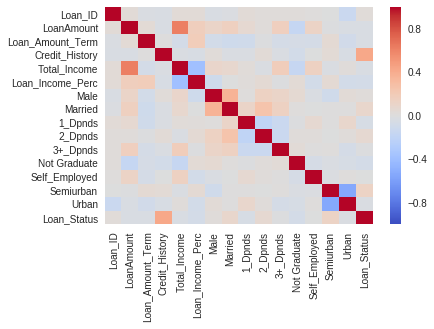

In [0]:
sns.heatmap(data.corr(),cmap='coolwarm')



# > **Model Selection (Gradient Boosting Classifier)**



In [0]:
from sklearn import ensemble, model_selection

In [0]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data.drop(['Loan_Status','Loan_ID'],axis=1),data['Loan_Status'].values.reshape((592,1)),
                                 random_state=42,shuffle=True,test_size=0.25,stratify=data['Loan_Status'])

In [0]:
model = ensemble.GradientBoostingClassifier(loss='exponential',n_estimators=100,max_depth=3,random_state=42,presort=True,verbose=0)

In [0]:
params_grid = {'max_depth':[3,4,5,6], 'n_estimators':[100,250,500,750,1000], 'warm_start': [False], 'max_features': ['sqrt','log2',None]}

In [0]:
tune_model = model_selection.GridSearchCV(model,scoring='roc_auc',param_grid=params_grid)

In [0]:
tune_model.fit(X_train,y_train.ravel())

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, presort=True,
              random_state=42, subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 4, 5, 6], 'n_estimators': [100, 250, 500, 750, 1000], 'warm_start': [False], 'max_features': ['sqrt', 'log2', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [0]:
tune_model.best_params_

{'max_depth': 3,
 'max_features': 'sqrt',
 'n_estimators': 100,
 'warm_start': False}

In [0]:
tune_model.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100, presort=True,
              random_state=42, subsample=1.0, verbose=0, warm_start=False)

In [0]:
predict = tune_model.predict(X_test)

In [0]:
tune_model.best_score_

0.7292366109684785

In [0]:
from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(y_test,predict))

[[18 27]
 [ 9 94]]


In [0]:
print(classification_report(y_test,predict))

             precision    recall  f1-score   support

          0       0.67      0.40      0.50        45
          1       0.78      0.91      0.84       103

avg / total       0.74      0.76      0.74       148



In [0]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, predict))

0.7567567567567568


# **GradientBoosting Scores**

Without Shuffling Accuracy_Score = 0.45

CFM 16,28,52,52


---



With Shuffling Accuracy = 0.7229

CFM 15,30,11,92


---



With loss set to Exponential, Accuracy = 0.7364

CFM 17, 28, 11, 92


---

With max_features set to sqrt (reduce key features by using square root algo)

Accuracy = 0.7567

CFM 18, 27, 9, 94



# > **Validation Set**



In [0]:
!wget "https://www.dropbox.com/s/v8gujc244yuqly0/test_Y3wMUE5_7gLdaTN.csv?dl=0" -q
!mv test* validation.csv

In [0]:
prod_data = pd.read_csv('validation.csv')

In [0]:
prod_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 12 columns):
Loan_ID              367 non-null object
Gender               356 non-null object
Married              367 non-null object
Dependents           357 non-null object
Education            367 non-null object
Self_Employed        344 non-null object
ApplicantIncome      367 non-null int64
CoapplicantIncome    367 non-null int64
LoanAmount           362 non-null float64
Loan_Amount_Term     361 non-null float64
Credit_History       338 non-null float64
Property_Area        367 non-null object
dtypes: float64(3), int64(2), object(7)
memory usage: 34.5+ KB


# > Impute missing values on production set



In [0]:
prod_data['Gender'] = prod_data[['Gender','ApplicantIncome','CoapplicantIncome']].apply(impute_gen,axis=1)

prod_data['Dependents'] = prod_data[['Dependents']].where(prod_data.Dependents.notnull(),other=str(0))

prod_data['Self_Employed'] = prod_data[['Self_Employed','Education']].apply(impute_employment,axis=1)

prod_data['Total_Income'] = prod_data.ApplicantIncome + prod_data.CoapplicantIncome

In [0]:
prod_data_loan_amt_by_area = prod_data[['Property_Area','LoanAmount']]
pd.pivot_table(prod_data_loan_amt_by_area,index=['Property_Area'],values=['LoanAmount'],aggfunc=np.mean)


,LoanAmount
Property_Area,
Rural,138.181818
Semiurban,134.043860
Urban,136.224638


In [0]:
def impute_prod_loan_amount(cols):
  area = cols[0]
  loan_amt = cols[1]
  
  if np.isnan(loan_amt):
    if area == "Rural":
      return float(138.0)
    if area == "Semiurban":
      return float(134.0)
    if area == "Urban":
      return float(136.0)
  else:
    return loan_amt

In [0]:
prod_data['LoanAmount'] = prod_data[['Property_Area','LoanAmount']].apply(impute_prod_loan_amount,axis=1)

In [0]:
prod_data['Loan_Income_Perc'] = round(prod_data.LoanAmount*1000/prod_data.Total_Income,2)

In [0]:
def impute_prod_loan_term(cols):
  Property_Area = cols[0]
  Loan_Income_Perc = cols[1]
  Loan_Term = cols[2]
  
  if Loan_Term > 0:
    return Loan_Term
  else:
    if Property_Area == "Rural" and Loan_Income_Perc > 24:
      return float(360)
    if Property_Area == "Semiurban" and Loan_Income_Perc > 25:
      return float(360)
    if Property_Area == "Urban" and Loan_Income_Perc > 23:
      return float(360)
    if Property_Area == "Rural" and Loan_Income_Perc > 23 and Loan_Income_Perc < 24:
      return float(345)
    if Property_Area == "Semiurban" and Loan_Income_Perc > 23 and Loan_Income_Perc < 24:
      return float(347)
    if Property_Area == "Urban" and Loan_Income_Perc > 22 and Loan_Income_Perc < 23:
      return float(328)
    if Loan_Income_Perc > 10:
      return float(360)
    if Loan_Income_Perc < 10:
      return float(180)

In [0]:
prod_data['Loan_Amount_Term'] = prod_data[['Property_Area','Loan_Income_Perc','Loan_Amount_Term']].apply(impute_prod_loan_term,axis=1)

In [0]:
prod_data['Credit_History'] = prod_data['Credit_History'].where(prod_data.Credit_History.notnull(),other=0)

In [0]:
prod_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 14 columns):
Loan_ID              367 non-null object
Gender               367 non-null object
Married              367 non-null object
Dependents           367 non-null object
Education            367 non-null object
Self_Employed        367 non-null object
ApplicantIncome      367 non-null int64
CoapplicantIncome    367 non-null int64
LoanAmount           367 non-null float64
Loan_Amount_Term     367 non-null float64
Credit_History       367 non-null float64
Property_Area        367 non-null object
Total_Income         367 non-null int64
Loan_Income_Perc     367 non-null float64
dtypes: float64(4), int64(3), object(7)
memory usage: 40.2+ KB




# > One hot Encoding on Production set



In [0]:
Gender = pd.get_dummies(prod_data['Gender'],drop_first=True)
Married = pd.get_dummies(prod_data['Married'],drop_first=True)
Married.rename(index=int,columns={"Yes": "Married"},inplace=True)

Dependents = pd.get_dummies(prod_data['Dependents'],drop_first=True)
Dependents.rename(index=int,columns={"1": "1_Dpnds", "2": "2_Dpnds", "3+": "3+_Dpnds"},inplace=True)

Education = pd.get_dummies(prod_data['Education'],drop_first=True)

Self_Employed = pd.get_dummies(prod_data['Self_Employed'],drop_first=True)
Self_Employed.rename(index=int,columns={"Yes": "Self_Employed"},inplace=True)

Property_Area = pd.get_dummies(prod_data['Property_Area'],drop_first=True)

Loan_ID = prod_data['Loan_ID']
id_df = pd.DataFrame(Loan_ID,columns=['Loan_ID'])

prod_data.drop(columns=['Gender','Married','Dependents','Education','Self_Employed','Property_Area','ApplicantIncome','CoapplicantIncome','Loan_ID'],axis=1,inplace=True)
prod_data = pd.concat([prod_data,Gender,Married,Dependents,Education,Self_Employed,Property_Area],axis=1)




# > Predict using Tuned Model



In [0]:
target = tune_model.predict(prod_data)



# > **Creating Final Dataset for Submission**



In [0]:
target_df = pd.DataFrame(target,columns=['LoanStatus'])

In [0]:
result = pd.concat([id_df,target_df],axis=1)

In [0]:
def convert_01_to_yn(cols):
  status = cols[0]
  
  if status == 0:
    return 'N'
  else:
    return 'Y'

In [0]:
result['Loan_Status'] = result[['LoanStatus']].apply(convert_01_to_yn,axis=1)

In [0]:
result.drop(['LoanStatus'],axis=1,inplace=True)

In [0]:
#result.rename(index=str,columns={"LoanStatus":"Loan_Status"},inplace=True)



# **> Save & Download Result**



In [0]:
result.to_csv('loan_prediction_result.csv',index=False)

In [0]:
from google.colab import files

In [0]:
files.download('loan_prediction_result.csv')